In [1]:
import torch
import gc

print("=== GPU 상태 확인 ===")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"현재 장치: {torch.cuda.current_device()}")
print(f"GPU 개수: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"\nGPU {i}:")
    print(f"  이름: {torch.cuda.get_device_name(i)}")
    print(f"  메모리 사용량: {torch.cuda.memory_allocated(i)/1e9:.2f} GB")
    print(f"  메모리 예약량: {torch.cuda.memory_reserved(i)/1e9:.2f} GB")
    print(f"  전체 메모리: {torch.cuda.get_device_properties(i).total_memory/1e9:.2f} GB")

=== GPU 상태 확인 ===
CUDA 사용 가능: True
현재 장치: 0
GPU 개수: 4

GPU 0:
  이름: NVIDIA GeForce RTX 4070 Ti SUPER
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.72 GB

GPU 1:
  이름: NVIDIA GeForce RTX 4070 Ti SUPER
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.72 GB

GPU 2:
  이름: NVIDIA RTX A4000
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.75 GB

GPU 3:
  이름: NVIDIA RTX A4000
  메모리 사용량: 0.00 GB
  메모리 예약량: 0.00 GB
  전체 메모리: 16.75 GB


In [1]:
# 필요한 라이브러리들을 임포트합니다.
import torch
import sqlite3
import hashlib
import json
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
from torch_geometric.data import Data

# --- 설정 변수 ---
CACHE_DIR = "cache/"
DB_PATH = "data/speech_segments.db"

# --- 프로젝트의 해시 함수를 그대로 가져옵니다 ---
def _hash(key: str) -> str:
    """비디오 ID를 캐시 파일명으로 변환하는 해시 함수"""
    return hashlib.md5(key.encode()).hexdigest() + ".pt"

print("✅ 1. 데이터베이스에서 모든 비디오 ID를 로드합니다.")
conn = sqlite3.connect(DB_PATH)
conn.row_factory = sqlite3.Row
try:
    # SQL 쿼리를 통해 DB에서 모든 고유한 video_id를 가져옵니다.
    all_videos_in_db = [row["video_id"] for row in conn.execute("SELECT DISTINCT video_id FROM video_metadata")]
    print(f"  - 데이터베이스에서 총 {len(all_videos_in_db)}개의 고유 비디오 ID를 찾았습니다.")
except sqlite3.OperationalError as e:
    print(f"\n[오류] 데이터베이스를 읽는 중 문제가 발생했습니다: {e}")
    print("DB 파일 경로가 정확한지, 테이블 이름이 올바른지 확인해주세요.")
    # 오류 발생 시 conn을 닫고 싶다면 여기에 추가
    # conn.close()

print("\n✅ 2. 각 비디오 ID에 해당하는 캐시 파일의 존재 여부 및 유효성을 검사합니다.")
available_video_ids = []
corrupted_files_count = 0
for video_id in tqdm(all_videos_in_db, desc="Verifying cache files"):
    cache_key = f"video_graph::{video_id}"
    graph_path = Path(CACHE_DIR) / _hash(cache_key)
    
    if graph_path.exists():
        try:
            # 파일이 존재하는 경우, 내용이 유효한지 확인
            data = torch.load(graph_path, map_location="cpu", weights_only=False)
            if isinstance(data, Data):
                # 로드한 데이터가 그래프 객체가 맞으면 사용 가능한 ID 목록에 추가
                available_video_ids.append(video_id)
        except Exception:
            # 파일을 로드하는 데 실패하면 손상된 파일로 간주
            corrupted_files_count += 1
            continue

print(f"  - 검사 완료. 총 {len(available_video_ids)}개의 유효한 그래프 캐시 파일을 확인했습니다.")
if corrupted_files_count > 0:
    print(f"  - 경고: {corrupted_files_count}개의 손상되었거나 읽을 수 없는 파일이 발견되어 제외되었습니다.")


print("\n✅ 3. 유효한 비디오 ID를 바탕으로 최종 데이터셋을 구성합니다.")
dataset_records = []
for video_id in tqdm(available_video_ids, desc="Building dataset"):
    meta = conn.execute(
        "SELECT persons_found FROM video_metadata WHERE video_id=?", (video_id,)
    ).fetchone()
    
    if meta and meta["persons_found"]:
        persons_data = json.loads(meta["persons_found"])
        for person_name, label_value in persons_data.items():
            dataset_records.append({
                "video_id": video_id,
                "person": person_name,
                "label": int(label_value)
            })

conn.close() # 데이터베이스 연결 종료

# 최종적으로 pandas 데이터프레임으로 변환
df_dataset = pd.DataFrame(dataset_records)

print("\n🎉 데이터셋 구성 완료!")
print(f"  - 총 {len(df_dataset)}개의 학습 샘플(video_id-person 쌍)을 생성했습니다.")
print("\n--- 데이터셋 샘플 (상위 5개) ---")
print(df_dataset.head())

/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseS

✅ 1. 데이터베이스에서 모든 비디오 ID를 로드합니다.
  - 데이터베이스에서 총 7335개의 고유 비디오 ID를 찾았습니다.

✅ 2. 각 비디오 ID에 해당하는 캐시 파일의 존재 여부 및 유효성을 검사합니다.


Verifying cache files: 100%|██████████| 7335/7335 [00:21<00:00, 334.23it/s]


  - 검사 완료. 총 6746개의 유효한 그래프 캐시 파일을 확인했습니다.

✅ 3. 유효한 비디오 ID를 바탕으로 최종 데이터셋을 구성합니다.


Building dataset: 100%|██████████| 6746/6746 [00:00<00:00, 83605.25it/s]


🎉 데이터셋 구성 완료!
  - 총 20664개의 학습 샘플(video_id-person 쌍)을 생성했습니다.

--- 데이터셋 샘플 (상위 5개) ---
      video_id         person  label
0  --6VaQ-Y0R4  Kamala Harris      1
1  --6VaQ-Y0R4   Gavin Newsom      1
2  --6VaQ-Y0R4   Donald Trump      0
3  -0KVHlRomHw   Nigel Farage      1
4  -0KVHlRomHw     Tony Blair      1


In [2]:
# --- 설정 변수 ---
OUTPUT_CSV_PATH = "available_dataset.csv"

print(f"✅ 데이터프레임을 CSV 파일로 저장합니다.")
try:
    # to_csv 메소드를 사용하여 데이터프레임을 저장합니다.
    # index=False 옵션은 데이터프레임의 인덱스가 파일에 저장되지 않도록 합니다.
    df_dataset.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8')
    print(f"  - 성공! 데이터셋이 '{OUTPUT_CSV_PATH}' 경로에 저장되었습니다.")
except Exception as e:
    print(f"\n[오류] CSV 파일 저장 중 문제가 발생했습니다: {e}")

✅ 데이터프레임을 CSV 파일로 저장합니다.
  - 성공! 데이터셋이 'available_dataset.csv' 경로에 저장되었습니다.


In [2]:
# --- 설정 변수 ---
NUM_SAMPLES_TO_USE = 3000
RANDOM_STATE = 42  # 재현성 고정

print(f"✅ 전체 데이터셋에서 '클래스 균형'을 맞춰 총 {NUM_SAMPLES_TO_USE}개를 추출합니다.")

# 필수 컬럼 확인
if "label" not in df_dataset.columns:
    raise KeyError("df_dataset에 'label' 컬럼이 없습니다. 레이블 컬럼명을 확인하세요.")

# 클래스 목록/개수
classes = sorted(df_dataset["label"].unique())
K = len(classes)
if K == 0:
    raise ValueError("df_dataset에 유효한 클래스(label)가 없습니다.")

# 클래스별 타깃 샘플 수 계산
per_class = NUM_SAMPLES_TO_USE // K
remainder = NUM_SAMPLES_TO_USE % K

balanced_parts = []
for i, c in enumerate(classes):
    target = per_class + (1 if i < remainder else 0)  # 남는 몫을 앞 클래스부터 1개씩 배분
    df_c = df_dataset[df_dataset["label"] == c]

    # 소수 클래스가 target보다 적으면 중복 허용(replace=True)로 업샘플링하여 정확히 맞춥니다.
    replace = len(df_c) < target
    if len(df_c) == 0:
        raise ValueError(f"클래스 {c}의 샘플이 0개입니다. 최소 1개 이상 필요합니다.")

    sampled_c = df_c.sample(n=target, replace=replace, random_state=RANDOM_STATE + i)
    balanced_parts.append(sampled_c)

# 클래스별 샘플을 합치고 최종 셔플
df_experiment = (
    pd.concat(balanced_parts, axis=0)
      .sample(frac=1, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)

# 리포트
print("  - 클래스별 추출 개수:")
class_counts = df_experiment["label"].value_counts().sort_index()
for c in classes:
    print(f"    · label={c}: {int(class_counts.get(c, 0))}개")

print(f"\n  - 총 샘플 수: {len(df_experiment)}개 (요청: {NUM_SAMPLES_TO_USE}개)")
print("\n--- 실험용 데이터셋 샘플 (상위 5개) ---")
print(df_experiment.head())


✅ 전체 데이터셋에서 '클래스 균형'을 맞춰 총 3000개를 추출합니다.
  - 클래스별 추출 개수:
    · label=0: 1500개
    · label=1: 1500개

  - 총 샘플 수: 3000개 (요청: 3000개)

--- 실험용 데이터셋 샘플 (상위 5개) ---
      video_id         person  label
0  3uCYhevAJhM      Joe Biden      1
1  88Wf6rtD6_4    Marco Rubio      0
2  RpB6PylokV0  Michael Cohen      1
3  EreQdiebO3I   Donald Trump      0
4  tRJRHExxRb0  Kamala Harris      1


In [3]:
from sklearn.model_selection import train_test_split

# --- 설정 변수 ---
TEST_SET_SIZE = 0.2  # 20%를 테스트 세트로 사용
VALIDATION_SET_SIZE = 0.125 # 나머지 80% 중에서 12.5%를 검증 세트로 사용 (0.1 / 0.8 = 0.125)
RANDOM_STATE = 42 # 재현 가능성을 위해 랜덤 시드 고정

print(f"✅ 실험용 데이터셋을 7:1:2 비율(훈련:검증:테스트)로 분할합니다.")
print(f"  - 전체 샘플 수: {len(df_experiment)}개")

# --- 1단계: 훈련+검증 세트(80%)와 테스트 세트(20%)로 분할 ---
# stratify=df_experiment['label'] 옵션은 원본 데이터의 레이블(0, 1) 비율을
# 분할된 데이터셋에서도 최대한 유지시켜주는 역할을 합니다.
df_train_val, df_test = train_test_split(
    df_experiment,
    test_size=TEST_SET_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_experiment['label']
)

# --- 2단계: 훈련+검증 세트를 훈련 세트(70%)와 검증 세트(10%)로 분할 ---
df_train, df_val = train_test_split(
    df_train_val,
    test_size=VALIDATION_SET_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train_val['label']
)

print("\n--- 분할 결과 ---")
print(f"  - 훈련 세트 (train):   {len(df_train)}개 (약 {len(df_train)/len(df_experiment)*100:.1f}%)")
print(f"  - 검증 세트 (valid):   {len(df_val)}개 (약 {len(df_val)/len(df_experiment)*100:.1f}%)")
print(f"  - 테스트 세트 (test):    {len(df_test)}개 (약 {len(df_test)/len(df_experiment)*100:.1f}%)")


# --- 3단계: 각 데이터셋을 CSV 파일로 저장 ---
try:
    print("\n✅ 분할된 데이터셋을 각각 CSV 파일로 저장합니다.")
    df_train.to_csv("train_dataset.csv", index=False, encoding='utf-8')
    df_val.to_csv("validation_dataset.csv", index=False, encoding='utf-8')
    df_test.to_csv("test_dataset.csv", index=False, encoding='utf-8')
    print("  - 성공! train_dataset.csv, validation_dataset.csv, test_dataset.csv 파일이 생성되었습니다.")
except Exception as e:
    print(f"\n[오류] CSV 파일 저장 중 문제가 발생했습니다: {e}")

✅ 실험용 데이터셋을 7:1:2 비율(훈련:검증:테스트)로 분할합니다.
  - 전체 샘플 수: 3000개

--- 분할 결과 ---
  - 훈련 세트 (train):   2100개 (약 70.0%)
  - 검증 세트 (valid):   300개 (약 10.0%)
  - 테스트 세트 (test):    600개 (약 20.0%)

✅ 분할된 데이터셋을 각각 CSV 파일로 저장합니다.
  - 성공! train_dataset.csv, validation_dataset.csv, test_dataset.csv 파일이 생성되었습니다.


In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hashlib
from pathlib import Path
import math
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import RGCNConv

from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model


# ===== VRAM logger =====
def log_vram(stage: str, device=None):
    if not torch.cuda.is_available():
        print(f"[VRAM] {stage}: CUDA not available")
        return
    if device is None:
        device = torch.cuda.current_device()
    torch.cuda.synchronize(device)
    alloc = torch.cuda.memory_allocated(device) / (1024**3)
    reserv = torch.cuda.memory_reserved(device) / (1024**3)
    maxal = torch.cuda.max_memory_allocated(device) / (1024**3)
    print(f"[VRAM] {stage:<28} | alloc={alloc:6.2f} GB | reserved={reserv:6.2f} GB | max={maxal:6.2f} GB")


# ===================================================================
# 0. 전역 설정
# ===================================================================
CACHE_DIR = "cache/"
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

print("✅ 실행 시작")


# ===================================================================
# 1. 데이터셋 및 데이터로더
# ===================================================================
print("✅ 1. 분할된 CSV 파일들을 로드하여 데이터셋을 생성합니다.")

class ExperimentDataset(Dataset):
    def __init__(self, dataframe, cache_dir):
        self.samples = dataframe.to_dict('records')
        self.cache_dir = Path(cache_dir)

    def __len__(self):
        return len(self.samples)

    @staticmethod
    def _hash(key: str) -> str:
        return hashlib.md5(key.encode()).hexdigest() + ".pt"

    def __getitem__(self, idx: int) -> Data | None:
        meta = self.samples[idx]
        video_id, person, label = meta['video_id'], meta['person'], meta['label']
        graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
        try:
            graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

            # 비어 있는 그래프는 스킵
            if graph_data.num_nodes == 0:
                return None

            # 잘못된 엣지 인덱스 방어적 보정
            if graph_data.num_edges > 0:
                mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
                if not mask.all():
                    graph_data.edge_index = graph_data.edge_index[:, mask]
                    if hasattr(graph_data, 'edge_type'):
                        graph_data.edge_type = graph_data.edge_type[mask]

            # 추가 메타
            graph_data.label = torch.tensor([label], dtype=torch.float)
            graph_data.person = person
            return graph_data
        except Exception:
            # 캐시가 없거나 로드 실패 시 스킵
            return None


def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return batch if batch else None


df_train = pd.read_csv("train_dataset.csv")
df_val = pd.read_csv("validation_dataset.csv")

train_dataset = ExperimentDataset(df_train, CACHE_DIR)
val_dataset   = ExperimentDataset(df_val, CACHE_DIR)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"  - 훈련 데이터로더: {len(train_loader)}개 배치")
print(f"  - 검증 데이터로더: {len(val_loader)}개 배치")


# ===================================================================
# 2. 모델 정의 (R-GCN + ChatGLM2 + LoRA)
# ===================================================================
print("\n✅ 2. GCN을 포함한 전체 모델(GraphTokenManager)을 정의합니다.")

class RGCNEncoder(nn.Module):
    def __init__(self, in_dim=768, num_rel=6, num_layers=5, dropout=0.0):
        super().__init__()
        # 관계 타입에 +1 오프셋을 주기 위해 dummy relation 포함
        true_num_relations = num_rel + 1
        self.layers = nn.ModuleList(
            RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
        )
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        # ---- FP32 유지 ----
        h = x.to(torch.float32)
        safe_edge_type = edge_type.to(torch.long) + 1  # -1 방지용 오프셋
        for conv in self.layers:
            h = conv(h, edge_index, safe_edge_type)
            h = self.act(h)
            h = self.drop(h)
        return h


class GraphTokenManager(nn.Module):
    def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8):
        super().__init__()

        # ChatGLM2-6B는 FP16, device_map="auto"
        self.glm = AutoModel.from_pretrained(
            glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
        )
        self.base_device = self.glm.get_input_embeddings().weight.device
        self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

        # ---- GCN/Linear/Head는 FP32 유지 ----
        self.gcn = RGCNEncoder(in_dim=768, num_rel=6, num_layers=gcn_layers).to(self.base_device)
        self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
        self.cls_head = nn.Linear(4096, 1).to(self.base_device)

        # LoRA: GLM의 QKV에만 적용
        lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
        self.glm = get_peft_model(self.glm, lora_cfg)

        # 길이 제한 및 체크포인팅(메모리 절감)
        self.max_graph_tokens = 512   # 필요시 256~512로 조정
        if hasattr(self.glm, "gradient_checkpointing_enable"):
            self.glm.gradient_checkpointing_enable()

    def _num_text_tokens(self, data) -> int:
        n = 0
        if hasattr(data, "node_meta"):
            if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
                n = int(data.node_meta[0].get("text_nodes", 0))
            elif isinstance(data.node_meta, dict):
                n = int(data.node_meta.get("text_nodes", 0))
        return max(n, 0)

    def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
        """
        seq: [T, D] (FP32)
        K:   target length (<= T). if T<=K, returns seq as-is.
        청크 평균 풀링: T를 K로 요약. 모든 토큰에 gradient가 흐름.
        """
        T = seq.size(0)
        if T <= K:
            return seq
        chunk = math.ceil(T / K)
        pad_len = chunk * K - T
        if pad_len > 0:
            pad = seq[-1:].repeat(pad_len, 1)
            seq = torch.cat([seq, pad], dim=0)   # [chunk*K, D]
        seq = seq.view(K, chunk, -1).mean(dim=1) # [K, D]
        return seq

    def _get_glm_backbone(self):
        # peft wrapping 후 구조까지 커버
        backbone = getattr(self.glm, "transformer", None)
        if backbone is None:
            backbone = getattr(self.glm, "model", None)
        if backbone is None and hasattr(self.glm, "base_model"):
            backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
        if backbone is None:
            raise RuntimeError("ChatGLM backbone not found: expected `.transformer` or `.model` inside PEFT wrapper.")
        return backbone

    def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
        device = self.base_device
        if debug: log_vram("forward/start", device)

        # ---- GCN 입력은 FP32 ----
        data.x = data.x.to(torch.float32)
        data.edge_index = data.edge_index.to(torch.long)
        data.edge_type  = data.edge_type.to(torch.long)
        data = data.to(device)
        if debug:
            print(f"[DBG] x={tuple(data.x.shape)}, edge_index={tuple(data.edge_index.shape)}, edge_type={tuple(data.edge_type.shape)}")
            log_vram("after data.to(device)", device)

        # 1) R-GCN 인코딩 (FP32)
        node_h = self.gcn(data.x, data.edge_index, data.edge_type)
        if debug:
            print(f"[DBG] node_h={tuple(node_h.shape)} (dtype={node_h.dtype})")
            log_vram("after GCN", device)

        # 2) 텍스트 토큰만 선택 (없으면 전체 사용)
        num_text_tokens = self._num_text_tokens(data)
        utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
        if utterance_h.size(0) == 0:
            utterance_h = node_h.mean(dim=0, keepdim=True)
        if debug:
            print(f"[DBG] num_text_tokens={num_text_tokens}, utterance_h={tuple(utterance_h.shape)}")
            log_vram("after choosing text nodes", device)

        # 3) 청크 평균 풀링으로 길이 축약 (핵심)
        utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)  # [K, 768], K<=max_graph_tokens

        # 4) 그래프 토큰 차원 올리기 → [1, K, 4096] (FP32)
        graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)
        if debug:
            print(f"[DBG] graph_tokens_fp32={tuple(graph_tokens_fp32.shape)} (dtype={graph_tokens_fp32.dtype})")
            log_vram("after proj_up", device)

        # 5) 프롬프트 임베딩 (FP16)과 결합 (그래프 토큰을 FP16으로 캐스팅)
        prompt = (
            f"Instruction: Please predict whether Google search volume for {person} "
            f"will exhibit an anomaly (0=no, 1=yes).\n"
            f"Input: "
        )
        tok = self.tokenizer(prompt, return_tensors="pt").to(device)
        prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16
        if debug:
            print(f"[DBG] prompt_len={prompt_emb.size(1)}, prompt_emb={tuple(prompt_emb.shape)} (dtype={prompt_emb.dtype})")
            log_vram("after prompt_emb", device)

        graph_tokens = graph_tokens_fp32.to(dtype=prompt_emb.dtype)  # FP16으로 변환
        inputs_embeds = torch.cat([prompt_emb, graph_tokens], dim=1)
        if debug:
            total_len = inputs_embeds.size(1)
            print(f"[DBG] inputs_embeds={tuple(inputs_embeds.shape)}  (total_seq_len={total_len})")
            log_vram("after concat inputs_embeds", device)

        # dummy input_ids (길이만 맞추기용)
        b, s, _ = inputs_embeds.size()
        dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

        if debug: log_vram("before GLM forward", device)

        # ✅ GLM backbone을 직접 호출하여 last_hidden_state 획득
        backbone = self._get_glm_backbone()
        transformer_out = backbone(
            input_ids=dummy_ids,
            inputs_embeds=inputs_embeds,
            return_dict=True,
            use_cache=False,
            output_hidden_states=False,   # 메모리 절감
        )

        if debug: log_vram("after GLM forward", device)

        # 6) 그래프 토큰 구간만 평균 → cls_head는 FP32
        glen = prompt_emb.size(1)
        last_hidden = transformer_out.last_hidden_state      # [B, S, H]
        graph_repr = last_hidden[:, glen:, :].mean(dim=1)   # [B, H]

        # cls_head가 위치한 디바이스로 이동
        head_dev = self.cls_head.weight.device
        graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

        if debug:
            print(f"[DBG] last_hidden={tuple(last_hidden.shape)}, graph_repr={tuple(graph_repr.shape)}")
            log_vram("after mean pool", device)

        logits = self.cls_head(graph_repr).squeeze(-1)  # [B]
        if debug:
            print(f"[DBG] logits={tuple(logits.shape)} (dtype={logits.dtype})")
            log_vram("after cls_head", device)

        if label is None:
            return logits, None

        loss = nn.BCEWithLogitsLoss()(logits, label.to(head_dev, dtype=torch.float32))
        if debug: log_vram("after loss", device)
        return logits, loss


# ===================================================================
# 3. 훈련 + 평가 (지표 다양화, F1 기준) + 베스트 체크포인트 저장
# ===================================================================
print("\n✅ 3. 모델 훈련을 준비하고 10 에포크를 실행합니다.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"  - 사용 장치: {device}")

model = GraphTokenManager()
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)

print("  - 모델 및 옵티마이저 준비 완료.")
print("\n--- 훈련 시작 (10 에포크) ---")

N_EPOCHS = 10
best_f1 = -1.0
best_threshold = 0.5
best_state = None

model.train()
global_step = 0

# ----------------- 평가 함수 (다양한 지표 + F1 기준) -----------------
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device=None):
    model.eval()
    probs_list, labels_list = [], []

    for batch in tqdm(loader, desc="Evaluating"):
        if batch is None:
            continue
        g: Data = batch[0] if isinstance(batch, list) else batch
        logits, _ = model(g, g.person, g.label, debug=False)
        probs = torch.sigmoid(logits.detach())
        probs_list.append(probs.float().cpu())
        labels_list.append(g.label.detach().float().cpu())

    if len(probs_list) == 0:
        print("No validation samples.")
        return {}

    y_prob = torch.cat(probs_list).view(-1)        # [N]
    y_true = torch.cat(labels_list).view(-1)       # [N]
    y_true = (y_true > 0.5).float()

    # 기본 임계값 0.5
    y_pred_05 = (y_prob >= 0.5).float()
    tp = ((y_pred_05 == 1) & (y_true == 1)).sum().item()
    tn = ((y_pred_05 == 0) & (y_true == 0)).sum().item()
    fp = ((y_pred_05 == 1) & (y_true == 0)).sum().item()
    fn = ((y_pred_05 == 0) & (y_true == 1)).sum().item()

    def safe_div(a, b):
        return (a / b) if b != 0 else 0.0

    acc   = safe_div(tp + tn, tp + tn + fp + fn)
    prec  = safe_div(tp, tp + fp)
    rec   = safe_div(tp, tp + fn)
    f1_05 = safe_div(2 * prec * rec, prec + rec)

    # 최적 F1 임계값 탐색 (grid)
    best_f1_local, best_t, best_prec, best_rec = 0.0, 0.5, 0.0, 0.0
    for t in torch.linspace(0.05, 0.95, steps=19):
        y_pred = (y_prob >= t).float()
        tp_t = ((y_pred == 1) & (y_true == 1)).sum().item()
        fp_t = ((y_pred == 1) & (y_true == 0)).sum().item()
        fn_t = ((y_pred == 0) & (y_true == 1)).sum().item()
        p_t  = safe_div(tp_t, tp_t + fp_t)
        r_t  = safe_div(tp_t, tp_t + fn_t)
        f1_t = safe_div(2 * p_t * r_t, p_t + r_t)
        if f1_t > best_f1_local:
            best_f1_local, best_t, best_prec, best_rec = f1_t, float(t.item()), p_t, r_t

    # ROC-AUC (rank-based, ties=average)
    def roc_auc_score_torch(y_true_, y_score_):
        y_true_ = y_true_.view(-1)
        y_score_ = y_score_.view(-1)
        n = y_true_.numel()
        n_pos = int((y_true_ == 1).sum().item())
        n_neg = n - n_pos
        if n_pos == 0 or n_neg == 0:
            return float('nan')
        _, order = torch.sort(y_score_)
        ranks = torch.empty_like(order, dtype=torch.float)
        ranks[order] = torch.arange(1, n + 1, dtype=torch.float)
        sum_ranks_pos = ranks[y_true_ == 1].sum()
        auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
        return float(auc.item())

    # PR-AUC (Average Precision)
    def average_precision_torch(y_true_, y_score_):
        scores, idx = torch.sort(y_score_.view(-1), descending=True)
        y_sorted = y_true_.view(-1)[idx]
        cum_tp = torch.cumsum(y_sorted, dim=0)
        ranks  = torch.arange(1, y_sorted.numel() + 1, dtype=torch.float)
        precision_at_k = cum_tp / ranks
        num_pos = y_sorted.sum()
        if num_pos.item() == 0:
            return float('nan')
        ap = (precision_at_k * y_sorted).sum() / num_pos
        return float(ap.item())

    roc_auc = roc_auc_score_torch(y_true, y_prob)
    pr_auc  = average_precision_torch(y_true, y_prob)

    metrics = {
        "accuracy": acc,
        "precision@0.5": prec,
        "recall@0.5": rec,
        "f1@0.5": f1_05,
        "best_f1": best_f1_local,
        "best_threshold": best_t,
        "best_precision": best_prec,
        "best_recall": best_rec,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "confusion_matrix@0.5": {"tp": tp, "tn": tn, "fp": fp, "fn": fn},
    }
    return metrics


# ----------------- 학습 루프 (10 에포크, 베스트 체크포인트 저장) -----------------
for epoch in range(1, N_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    num_steps  = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{N_EPOCHS}")

    for batch in progress_bar:
        if batch is None:
            continue
        graph_batch: Data = batch[0] if isinstance(batch, list) else batch

        logits, loss = model(graph_batch, graph_batch.person, graph_batch.label, debug=False)

        if loss is not None and torch.isfinite(loss):
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            total_loss += float(loss.item())
            num_steps  += 1

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = (total_loss / max(num_steps, 1))
    print(f"[Epoch {epoch}] train_loss={avg_loss:.4f}")

    # --- 에폭 종료 후 검증 & 베스트 체크포인트 갱신 ---
    val_metrics = evaluate(model, val_loader, device=device)
    print(f"[Epoch {epoch}] "
          f"val_f1@0.5={val_metrics.get('f1@0.5', float('nan')):.4f} | "
          f"best_f1={val_metrics.get('best_f1', float('nan')):.4f} "
          f"(thr={val_metrics.get('best_threshold', 0.5):.2f})")

    cur_best_f1 = val_metrics.get('best_f1', -1.0)
    if cur_best_f1 > best_f1:
        best_f1 = cur_best_f1
        best_threshold = float(val_metrics.get('best_threshold', 0.5))
        # 상태 저장
        best_state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_f1": best_f1,
            "best_threshold": best_threshold,
            "metrics": val_metrics,
        }
        torch.save(best_state, "best_checkpoint.pt")
        print(f"✅ Saved best checkpoint: epoch={epoch}, best_f1={best_f1:.4f}, thr={best_threshold:.2f}")

print(f"--- 훈련 완료 ({N_EPOCHS} 에포크) ---")
if best_state is not None:
    print(f"📦 Best checkpoint -> epoch={best_state['epoch']}, "
          f"F1={best_state['best_f1']:.4f}, thr={best_state['best_threshold']:.2f}, "
          f"file='best_checkpoint.pt'")
else:
    print("⚠️ Best checkpoint was not updated.")


✅ 실행 시작
✅ 1. 분할된 CSV 파일들을 로드하여 데이터셋을 생성합니다.
  - 훈련 데이터로더: 2100개 배치
  - 검증 데이터로더: 300개 배치

✅ 2. GCN을 포함한 전체 모델(GraphTokenManager)을 정의합니다.

✅ 3. 모델 훈련을 준비하고 10 에포크를 실행합니다.
  - 사용 장치: cuda:0


Loading checkpoint shards: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


  - 모델 및 옵티마이저 준비 완료.

--- 훈련 시작 (10 에포크) ---


Epoch 1/10:   0%|          | 0/2100 [00:00<?, ?it/s]/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 1/10: 100%|██████████| 2100/2100 [21:46<00:00,  1.61it/s, loss=0.8325]


[Epoch 1] train_loss=0.7770


Evaluating: 100%|██████████| 300/300 [00:52<00:00,  5.77it/s]


[Epoch 1] val_f1@0.5=0.6462 | best_f1=0.6667 (thr=0.05)
✅ Saved best checkpoint: epoch=1, best_f1=0.6667, thr=0.05


Epoch 2/10: 100%|██████████| 2100/2100 [21:42<00:00,  1.61it/s, loss=1.0188]


[Epoch 2] train_loss=0.7206


Evaluating: 100%|██████████| 300/300 [00:52<00:00,  5.76it/s]


[Epoch 2] val_f1@0.5=0.5705 | best_f1=0.6667 (thr=0.05)


Epoch 3/10: 100%|██████████| 2100/2100 [21:40<00:00,  1.62it/s, loss=0.5201]


[Epoch 3] train_loss=0.7131


Evaluating: 100%|██████████| 300/300 [00:52<00:00,  5.76it/s]


[Epoch 3] val_f1@0.5=0.0132 | best_f1=0.6636 (thr=0.05)


Epoch 4/10: 100%|██████████| 2100/2100 [21:37<00:00,  1.62it/s, loss=0.3006]


[Epoch 4] train_loss=0.7051


Evaluating: 100%|██████████| 300/300 [00:51<00:00,  5.77it/s]


[Epoch 4] val_f1@0.5=0.6651 | best_f1=0.6713 (thr=0.45)
✅ Saved best checkpoint: epoch=4, best_f1=0.6713, thr=0.45


Epoch 5/10: 100%|██████████| 2100/2100 [21:37<00:00,  1.62it/s, loss=0.3231]


[Epoch 5] train_loss=0.6788


Evaluating: 100%|██████████| 300/300 [00:51<00:00,  5.78it/s]


[Epoch 5] val_f1@0.5=0.1059 | best_f1=0.6697 (thr=0.20)


Epoch 6/10: 100%|██████████| 2100/2100 [18:22<00:00,  1.90it/s, loss=0.5206]


[Epoch 6] train_loss=0.6815


Evaluating: 100%|██████████| 300/300 [00:51<00:00,  5.78it/s]


[Epoch 6] val_f1@0.5=0.0000 | best_f1=0.2788 (thr=0.05)


Epoch 7/10: 100%|██████████| 2100/2100 [10:34<00:00,  3.31it/s, loss=0.1019]


[Epoch 7] train_loss=0.7119


Evaluating: 100%|██████████| 300/300 [00:51<00:00,  5.78it/s]


[Epoch 7] val_f1@0.5=0.0510 | best_f1=0.2929 (thr=0.15)


Epoch 8/10: 100%|██████████| 2100/2100 [07:26<00:00,  4.70it/s, loss=2.4126]


[Epoch 8] train_loss=0.7074


Evaluating: 100%|██████████| 300/300 [00:51<00:00,  5.80it/s]


[Epoch 8] val_f1@0.5=0.0000 | best_f1=0.1091 (thr=0.05)


Epoch 9/10: 100%|██████████| 2100/2100 [06:33<00:00,  5.33it/s, loss=0.9475]


[Epoch 9] train_loss=0.7537


Evaluating: 100%|██████████| 300/300 [00:51<00:00,  5.80it/s]


[Epoch 9] val_f1@0.5=0.0000 | best_f1=0.0000 (thr=0.50)


Epoch 10/10: 100%|██████████| 2100/2100 [06:19<00:00,  5.53it/s, loss=0.7947]


[Epoch 10] train_loss=0.6655


Evaluating: 100%|██████████| 300/300 [00:51<00:00,  5.80it/s]

[Epoch 10] val_f1@0.5=0.0000 | best_f1=0.0000 (thr=0.50)
--- 훈련 완료 (10 에포크) ---
📦 Best checkpoint -> epoch=4, F1=0.6713, thr=0.45, file='best_checkpoint.pt'


In [2]:
# === Setup cell: run this ONCE after kernel restart ===
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path
import math
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import RGCNConv

from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model

CACHE_DIR = "cache/"

class ExperimentDataset(Dataset):
    def __init__(self, dataframe, cache_dir):
        self.samples = dataframe.to_dict('records')
        self.cache_dir = Path(cache_dir)
    def __len__(self):
        return len(self.samples)
    @staticmethod
    def _hash(key: str) -> str:
        import hashlib
        return hashlib.md5(key.encode()).hexdigest() + ".pt"
    def __getitem__(self, idx: int) -> Data | None:
        meta = self.samples[idx]
        video_id = meta.get('video_id')
        person   = meta.get('person')
        label    = meta.get('label', None)
        graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
        try:
            graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)
            if graph_data.num_nodes == 0:
                return None
            if graph_data.num_edges > 0:
                mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
                if not mask.all():
                    graph_data.edge_index = graph_data.edge_index[:, mask]
                    if hasattr(graph_data, 'edge_type'):
                        graph_data.edge_type = graph_data.edge_type[mask]
            # attach meta needed at inference
            if label is not None:
                graph_data.label = torch.tensor([label], dtype=torch.float)
            graph_data.person   = person
            graph_data.video_id = video_id
            return graph_data
        except Exception:
            return None

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return batch if batch else None

class RGCNEncoder(nn.Module):
    def __init__(self, in_dim=768, num_rel=6, num_layers=5, dropout=0.0):
        super().__init__()
        true_num_relations = num_rel + 1
        self.layers = nn.ModuleList(
            RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
        )
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x, edge_index, edge_type):
        h = x.to(torch.float32)
        safe_edge_type = edge_type.to(torch.long) + 1
        for conv in self.layers:
            h = conv(h, edge_index, safe_edge_type)
            h = self.act(h); h = self.drop(h)
        return h

class GraphTokenManager(nn.Module):
    def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8):
        super().__init__()
        self.glm = AutoModel.from_pretrained(
            glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
        )
        self.base_device = self.glm.get_input_embeddings().weight.device
        self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

        self.gcn = RGCNEncoder(in_dim=768, num_rel=6, num_layers=gcn_layers).to(self.base_device)
        self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
        self.cls_head = nn.Linear(4096, 1).to(self.base_device)

        lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
        self.glm = get_peft_model(self.glm, lora_cfg)

        self.max_graph_tokens = 512
        if hasattr(self.glm, "gradient_checkpointing_enable"):
            self.glm.gradient_checkpointing_enable()

    def _num_text_tokens(self, data) -> int:
        n = 0
        if hasattr(data, "node_meta"):
            if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
                n = int(data.node_meta[0].get("text_nodes", 0))
            elif isinstance(data.node_meta, dict):
                n = int(data.node_meta.get("text_nodes", 0))
        return max(n, 0)

    def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
        T = seq.size(0)
        if T <= K:
            return seq
        chunk = math.ceil(T / K)
        pad_len = chunk * K - T
        if pad_len > 0:
            pad = seq[-1:].repeat(pad_len, 1)
            seq = torch.cat([seq, pad], dim=0)
        return seq.view(K, chunk, -1).mean(dim=1)

    def _get_glm_backbone(self):
        backbone = getattr(self.glm, "transformer", None)
        if backbone is None:
            backbone = getattr(self.glm, "model", None)
        if backbone is None and hasattr(self.glm, "base_model"):
            backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
        if backbone is None:
            raise RuntimeError("ChatGLM backbone not found under PEFT wrapper.")
        return backbone

    def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
        device = self.base_device

        data.x = data.x.to(torch.float32)
        data.edge_index = data.edge_index.to(torch.long)
        data.edge_type  = data.edge_type.to(torch.long)
        data = data.to(device)

        node_h = self.gcn(data.x, data.edge_index, data.edge_type)

        num_text_tokens = self._num_text_tokens(data)
        utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
        if utterance_h.size(0) == 0:
            utterance_h = node_h.mean(dim=0, keepdim=True)

        utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)

        graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)

        prompt = (
            f"Instruction: Please predict whether Google search volume for {person} "
            f"will exhibit an anomaly (0=no, 1=yes).\n"
            f"Input: "
        )
        tok = self.tokenizer(prompt, return_tensors="pt").to(device)
        prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16

        inputs_embeds = torch.cat(
            [prompt_emb, graph_tokens_fp32.to(dtype=prompt_emb.dtype)], dim=1
        )
        b, s, _ = inputs_embeds.size()
        dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

        backbone = self._get_glm_backbone()
        out = backbone(
            input_ids=dummy_ids,
            inputs_embeds=inputs_embeds,
            return_dict=True,
            use_cache=False,
            output_hidden_states=False,
        )

        glen = prompt_emb.size(1)
        last_hidden = out.last_hidden_state
        graph_repr = last_hidden[:, glen:, :].mean(dim=1)

        head_dev = self.cls_head.weight.device
        graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

        logits = self.cls_head(graph_repr).squeeze(-1)

        if label is None:
            return logits, None
        loss = nn.BCEWithLogitsLoss()(logits, label.to(head_dev, dtype=torch.float32))
        return logits, loss


In [3]:
# =======================
# Inference All-in-One
# =======================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path
import math
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import RGCNConv

from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model


# -----------------------
# 0) 전역 설정
# -----------------------
CACHE_DIR = "cache/"
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

# 테스트 설정
CHECKPOINT_PATH = "best_checkpoint.pt"
TEST_DATA_PATH = "test_dataset.csv"
PREDICTION_OUTPUT_PATH = "test_predictions.csv"
MAX_GRAPH_TOKENS = 512   # 필요시 256 등으로 낮추면 VRAM 여유↑


# -----------------------
# 1) 데이터셋/로더 정의
# -----------------------
class ExperimentDataset(Dataset):
    def __init__(self, dataframe, cache_dir):
        self.samples = dataframe.to_dict('records')
        self.cache_dir = Path(cache_dir)

    def __len__(self):
        return len(self.samples)

    @staticmethod
    def _hash(key: str) -> str:
        import hashlib
        return hashlib.md5(key.encode()).hexdigest() + ".pt"

    def __getitem__(self, idx: int) -> Data | None:
        meta = self.samples[idx]
        video_id = meta.get('video_id')
        person   = meta.get('person')
        label    = meta.get('label', None)

        graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
        try:
            graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

            # 비어있는 그래프 방어
            if graph_data.num_nodes == 0:
                return None

            # 잘못된 엣지 인덱스 방어
            if graph_data.num_edges > 0:
                mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
                if not mask.all():
                    graph_data.edge_index = graph_data.edge_index[:, mask]
                    if hasattr(graph_data, 'edge_type'):
                        graph_data.edge_type = graph_data.edge_type[mask]

            # 메타 부착 (테스트 CSV에 label이 없어도 동작)
            if label is not None:
                graph_data.label = torch.tensor([label], dtype=torch.float)
            graph_data.person   = person
            graph_data.video_id = video_id
            return graph_data
        except Exception:
            return None


def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return batch if batch else None


# -----------------------
# 2) 모델 정의
# -----------------------
class RGCNEncoder(nn.Module):
    def __init__(self, in_dim=768, num_rel=6, num_layers=5, dropout=0.0):
        super().__init__()
        true_num_relations = num_rel + 1  # 오프셋용 dummy relation 포함
        self.layers = nn.ModuleList(
            RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
        )
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        h = x.to(torch.float32)
        safe_edge_type = edge_type.to(torch.long) + 1
        for conv in self.layers:
            h = conv(h, edge_index, safe_edge_type)
            h = self.act(h)
            h = self.drop(h)
        return h


class GraphTokenManager(nn.Module):
    def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8):
        super().__init__()
        # ChatGLM2를 FP16 + device_map='auto'로 로드(멀티 GPU/오프로딩 호환)
        self.glm = AutoModel.from_pretrained(
            glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
        )
        self.base_device = self.glm.get_input_embeddings().weight.device
        self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

        # GCN/Linear/Head는 FP32 (기본 디바이스는 GLM 임베딩의 디바이스)
        self.gcn = RGCNEncoder(in_dim=768, num_rel=6, num_layers=gcn_layers).to(self.base_device)
        self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
        self.cls_head = nn.Linear(4096, 1).to(self.base_device)

        # LoRA(QKV)
        lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
        self.glm = get_peft_model(self.glm, lora_cfg)

        # 길이 제한 + 체크포인팅
        self.max_graph_tokens = MAX_GRAPH_TOKENS
        if hasattr(self.glm, "gradient_checkpointing_enable"):
            self.glm.gradient_checkpointing_enable()

    def _num_text_tokens(self, data) -> int:
        n = 0
        if hasattr(data, "node_meta"):
            if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
                n = int(data.node_meta[0].get("text_nodes", 0))
            elif isinstance(data.node_meta, dict):
                n = int(data.node_meta.get("text_nodes", 0))
        return max(n, 0)

    def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
        """
        seq: [T, D], K: target length(<=T). T<=K면 그대로 반환.
        """
        T = seq.size(0)
        if T <= K:
            return seq
        chunk = math.ceil(T / K)
        pad_len = chunk * K - T
        if pad_len > 0:
            pad = seq[-1:].repeat(pad_len, 1)
            seq = torch.cat([seq, pad], dim=0)
        return seq.view(K, chunk, -1).mean(dim=1)

    def _get_glm_backbone(self):
        backbone = getattr(self.glm, "transformer", None)
        if backbone is None:
            backbone = getattr(self.glm, "model", None)
        if backbone is None and hasattr(self.glm, "base_model"):
            backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
        if backbone is None:
            raise RuntimeError("ChatGLM backbone not found under PEFT wrapper.")
        return backbone

    def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
        device = self.base_device

        # ---- GCN (FP32) ----
        data.x = data.x.to(torch.float32)
        data.edge_index = data.edge_index.to(torch.long)
        data.edge_type  = data.edge_type.to(torch.long)
        data = data.to(device)

        node_h = self.gcn(data.x, data.edge_index, data.edge_type)

        # 텍스트 노드만 (없으면 전체)
        num_text_tokens = self._num_text_tokens(data)
        utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
        if utterance_h.size(0) == 0:
            utterance_h = node_h.mean(dim=0, keepdim=True)

        # 청크 평균 풀링 → 길이 K로 축약
        utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)  # [K, 768]

        # 768→4096 프로젝션
        graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)               # [1, K, 4096]

        # 프롬프트 임베딩(FP16) + 그래프 토큰(FP16)
        prompt = (
            f"Instruction: Please predict whether Google search volume for {person} "
            f"will exhibit an anomaly (0=no, 1=yes).\n"
            f"Input: "
        )
        tok = self.tokenizer(prompt, return_tensors="pt").to(device)
        prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)              # [1, P, 4096], fp16
        inputs_embeds = torch.cat([prompt_emb, graph_tokens_fp32.to(dtype=prompt_emb.dtype)], dim=1)

        # GLM backbone 호출 (히든만 필요)
        b, s, _ = inputs_embeds.size()
        dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)
        backbone = self._get_glm_backbone()
        out = backbone(
            input_ids=dummy_ids,
            inputs_embeds=inputs_embeds,
            return_dict=True,
            use_cache=False,
            output_hidden_states=False,
        )

        # 그래프 토큰 구간 평균 → cls_head
        glen = prompt_emb.size(1)
        last_hidden = out.last_hidden_state                                       # [1, P+K, 4096]
        graph_repr = last_hidden[:, glen:, :].mean(dim=1)                         # [1, 4096]

        head_dev = self.cls_head.weight.device
        graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)
        logits = self.cls_head(graph_repr).squeeze(-1)                            # [1]

        if label is None:
            return logits, None
        loss = nn.BCEWithLogitsLoss()(logits, label.to(head_dev, dtype=torch.float32))
        return logits, loss


# -----------------------
# 3) 체크포인트 로드 & 테스트 예측
# -----------------------
print("\n✅ 4. 저장된 최적 체크포인트로 테스트 데이터셋을 평가합니다.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"  - 사용 장치(참고용): {device}")
if not Path(CHECKPOINT_PATH).exists():
    raise FileNotFoundError(f"체크포인트 파일을 찾을 수 없습니다: {CHECKPOINT_PATH}")

# 모델 생성 (절대 .to(device)로 강제이동하지 않음)
test_model = GraphTokenManager()
test_model.max_graph_tokens = MAX_GRAPH_TOKENS

# 체크포인트는 CPU로 읽어서 state_dict만 주입 → VRAM 피크 방지
ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu")
missing, unexpected = test_model.load_state_dict(ckpt["model"], strict=False)
if missing or unexpected:
    print(f"[load_state_dict] missing={len(missing)}, unexpected={len(unexpected)}")
test_model.eval()

best_threshold = float(ckpt.get("best_threshold", 0.5))
print(f"  - 체크포인트 로드 완료 (Epoch {ckpt.get('epoch')}, Best F1={ckpt.get('best_f1'):.4f})")
print(f"  - 예측 임계값(threshold): {best_threshold:.2f}")

# 테스트 데이터 로드
df_test = pd.read_csv(TEST_DATA_PATH)
test_dataset = ExperimentDataset(df_test, CACHE_DIR)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
print(f"  - 테스트 데이터 로드 완료: {len(test_dataset)}개 샘플")

# 예측 수행
results = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        if batch is None:
            continue
        g = batch[0] if isinstance(batch, list) else batch

        logits, _ = test_model(g, g.person, None)
        prob = torch.sigmoid(logits).float().cpu().item()
        pred = 1 if prob >= best_threshold else 0

        # 테스트 CSV에 label이 없을 수도 있으니 안전 처리
        actual = int(g.label.cpu().item()) if hasattr(g, "label") else -1

        results.append({
            "video_id": getattr(g, "video_id", None),
            "person": getattr(g, "person", None),
            "actual_label": actual,
            "predicted_probability": f"{prob:.4f}",
            "final_prediction": pred
        })

# 결과 저장
df_results = pd.DataFrame(results)
df_results.to_csv(PREDICTION_OUTPUT_PATH, index=False, encoding="utf-8")

print("\n🎉 테스트 예측 완료!")
print(f"  - 결과가 '{PREDICTION_OUTPUT_PATH}' 파일에 저장되었습니다.")
print("\n--- 예측 결과 샘플 (상위 5개) ---")
print(df_results.head())



✅ 4. 저장된 최적 체크포인트로 테스트 데이터셋을 평가합니다.
  - 사용 장치(참고용): cuda:0


Loading checkpoint shards: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


  - 체크포인트 로드 완료 (Epoch 4, Best F1=0.6713)
  - 예측 임계값(threshold): 0.45
  - 테스트 데이터 로드 완료: 600개 샘플


Predicting on test set: 100%|██████████| 600/600 [01:45<00:00,  5.71it/s]



🎉 테스트 예측 완료!
  - 결과가 'test_predictions.csv' 파일에 저장되었습니다.

--- 예측 결과 샘플 (상위 5개) ---
        video_id            person  actual_label predicted_probability  \
0  [gY-okVLpgls]  [Vladimir Putin]             1                0.5955   
1  [7knzyKXD_hY]    [Donald Trump]             1                0.7720   
2  [aok_pE6q76A]       [Joe Biden]             0                0.5543   
3  [E3sQvyUtGyM]    [Donald Trump]             1                0.8720   
4  [x4ZBPAirVn0]   [Chuck Schumer]             0                0.6653   

   final_prediction  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  



📊 성능 지표
Accuracy  : 0.5067
Precision : 0.5035
Recall    : 0.9467
F1 Score  : 0.6574
ROC-AUC   : 0.5845
PR-AUC    : 0.5852

🔍 혼동행렬
          Pred 0  Pred 1
Actual 0      20     280
Actual 1      16     284


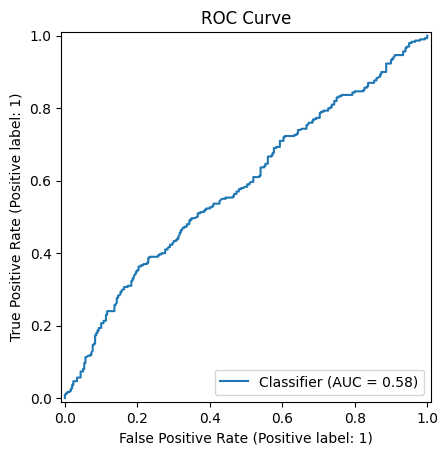

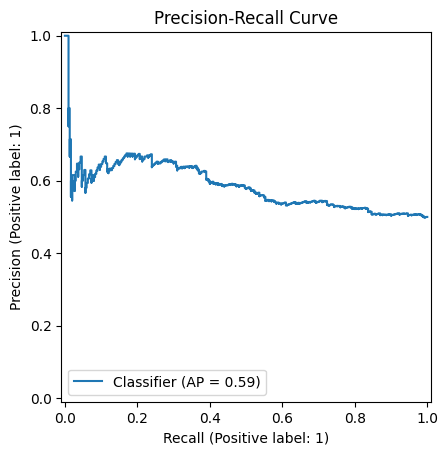


✅ 'test_metrics_summary.csv' 파일로 저장 완료!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

# --- 설정 ---
CSV_PATH = "test_predictions.csv"  # CSV 파일 경로

# --- 1. CSV 불러오기 ---
df = pd.read_csv(CSV_PATH)

if not {"actual_label", "final_prediction", "predicted_probability"}.issubset(df.columns):
    raise ValueError("CSV 파일에 'actual_label', 'final_prediction', 'predicted_probability' 컬럼이 필요합니다.")

y_true = df["actual_label"].astype(int)
y_pred = df["final_prediction"].astype(int)
y_prob = df["predicted_probability"].astype(float)

# --- 2. 성능 지표 계산 ---
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, zero_division=0),
    "Recall": recall_score(y_true, y_pred, zero_division=0),
    "F1 Score": f1_score(y_true, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_true, y_prob),
    "PR-AUC": average_precision_score(y_true, y_prob)
}

# --- 3. 혼동행렬 ---
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

# --- 4. 결과 출력 ---
print("\n📊 성능 지표")
for k, v in metrics.items():
    print(f"{k:<10}: {v:.4f}")

print("\n🔍 혼동행렬")
print(cm_df)

# --- 5. ROC Curve ---
RocCurveDisplay.from_predictions(y_true, y_prob)
plt.title("ROC Curve")
plt.show()

# --- 6. Precision-Recall Curve ---
PrecisionRecallDisplay.from_predictions(y_true, y_prob)
plt.title("Precision-Recall Curve")
plt.show()

# --- 7. 지표를 CSV로 저장 ---
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("test_metrics_summary.csv", index=False, encoding="utf-8")
print("\n✅ 'test_metrics_summary.csv' 파일로 저장 완료!")
